In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
plt.style.use(["science","grid"])
def normalise(arr):
    arrmax = np.max(arr)
    arrmin = np.min(arr)
    
    arrnorm = (arr - arrmin) / (arrmax - arrmin)
    
    return arrnorm
def ticks_labels(nb_days):
    if 30%nb_days != 0:
        raise ValueError 
    else:
        vec = np.linspace(0,4320,int(30/nb_days)+1)
        labs = list()
        for i in range(int(30/nb_days)+1):
            labs.append("Day %s"%(i*nb_days))
        return vec,labs

my_palette = {}
my_palette['dark'] = ['midnightblue', 'chocolate', 'darkolivegreen']
my_palette['light'] = ['cornflowerblue','orange','yellowgreen']
my_palette['reds'] = []

In [66]:
data = pd.read_feather("15dayration")
input_vars = pd.read_csv("input_parameters_15dayration.csv")

In [67]:
factor_names = ["alpha","beta","gamma","epsilon","parallel_served_full"]

scenarios = np.array([ [1.0, 0.0, 7.0, 0.1, 6.0], # No social interaction; low visiting frequency
              [0.0, 1.0, 7.0, 0.1, 6.0],
              [0.0, 1.0, 7.0, 1.0, 6.0], # Social interaction; low visiting frequency
              [0.0, 1.0, 3.0, 0.1, 7.8], # Social interaction; high visiting frequency
              [1.0, 0.0, 3.0, 0.1, 7.8]]) # Particular to capacity analysis icm queuing

In [68]:
q_sum = list()
n_facs = 12
for j in input_vars.index:
    tmp_sum = 0
    for i in range(n_facs):
        tmp_sum += ( np.sum(data[data.o0==j].iloc[:,i+4]))  
    
    q_sum.append(tmp_sum)    

uc_endvals_dict = {}
for i in ["unsatisfied consumption","policy type","variation","allfacs","fac5","food waste","distance"]:
    uc_endvals_dict[i] = list()


for j in input_vars.index:
    uc_endvals_dict["unsatisfied consumption"].append(data.o1[data.o0==j].iloc[-1])
    uc_endvals_dict["fac5"].append( np.sum(data[data.o0==j].iloc[:,9]))
    uc_endvals_dict["allfacs"].append( q_sum[j] )
    uc_endvals_dict["food waste"].append(data.o2[data.o0==j].iloc[-1])
    uc_endvals_dict["distance"].append(data.o3[data.o0==j].iloc[-1])

    if input_vars.capacity_policy[j] > 0:
        uc_endvals_dict["policy type"].append(1)
        uc_endvals_dict["variation"].append(input_vars.capacity_policy[j])
    elif input_vars.rerouting_policy[j] > 0:
        uc_endvals_dict["policy type"].append(2)
        uc_endvals_dict["variation"].append(input_vars.rerouting_policy[j]+1)
    else:
        uc_endvals_dict["policy type"].append(0)
        uc_endvals_dict["variation"].append(0)    

uc_endvals_df = pd.DataFrame(uc_endvals_dict)
input_vars_filtered = pd.concat([input_vars,uc_endvals_df],axis=1)

IndexError: single positional indexer is out-of-bounds

<ipython-input-59-86d84c342049>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0,100,6),fontsize=14)


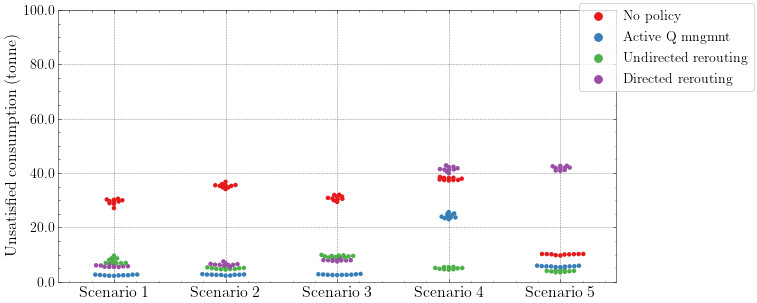

In [59]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

relevant_indices = [0,1,2,3,4]
relevant_scenarios = scenarios[ relevant_indices ]

# Modify DF for plot
storage_dict = {}
for s in range(len(relevant_scenarios)):
    tmp = input_vars_filtered
    
    for f in range(len(factor_names)):
        tmp = tmp[ tmp[factor_names[f]] == relevant_scenarios[s][f] ]
        
    tmp = pd.concat([tmp.reset_index(),pd.DataFrame({"scenario":np.ones(len(tmp))*s})],axis=1)
    storage_dict[s] = tmp
    
# Join dfs from dictionary 
tmp = pd.concat(storage_dict.values())
tmp = tmp[ np.invert( [all(t) for t in zip(tmp.capacity_policy!=0, tmp.rerouting_policy!=0)]) ]

sns.swarmplot(ax=ax ,x='scenario',hue='variation', y="unsatisfied consumption", data=tmp,size=4.5,palette="Set1")

# x-axis
ax.set_xlabel(None)
xticklabels = ["Scenario %s"%(i+1) for i in relevant_indices]
ax.set_xticklabels(xticklabels,fontsize=16)

# y-axis
ax.set_ylim([0,100e3])
ax.set_yticklabels(np.linspace(0,100,6),fontsize=14)
ax.set_ylabel("Unsatisfied consumption (tonne)",fontsize=16)

# grid
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

handles = ax.get_legend_handles_labels()[0]
labels = ["No policy","Active Q mngmnt","Undirected rerouting","Directed rerouting"]
ax.legend(handles[:4],labels,loc='upper left',fontsize=14,bbox_to_anchor=(0.92, 1.05),framealpha=0.75);

# plt.savefig("/home/daan/Desktop/results_uc_rerouting.png")input_vars_filtered